In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install ydata-synthetic lib
#! pip install ydata-synthetic

# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [1]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

2023-04-26 06:15:40.784188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
from epftoolbox.data import read_data

In [27]:
from epftoolbox.evaluation import MAE
from epftoolbox.evaluation import rMAE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import RMSE
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [162]:
#Specific to TimeGANs
seq_len=24
n_seq = 3
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [170]:
stock_data = processed_stock(path='../../examples/timeseries/BE.csv', seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

52392 (24, 3)


In [163]:
df_train, df_test = read_data(path='.', dataset='BE', begin_test_date='01-01-2016', end_test_date='02-01-2016')

Test datasets: 2016-01-01 00:00:00 - 2016-01-02 23:00:00


In [164]:
df_train

Price  Exogenous 1  Exogenous 2
Date                                                
2011-01-09 00:00:00  32.54      63065.0      63000.0
2011-01-09 01:00:00  21.55      62715.0      58800.0
2011-01-09 02:00:00  15.71      61952.0      58500.0
2011-01-09 03:00:00  10.58      59262.0      54300.0
2011-01-09 04:00:00  10.32      56883.0      51900.0
...                    ...          ...          ...
2015-12-31 19:00:00  36.79      65865.0      66413.0
2015-12-31 20:00:00  28.81      62630.0      64422.0
2015-12-31 21:00:00  26.27      59696.0      60622.0
2015-12-31 22:00:00  29.99      60570.0      57279.0
2015-12-31 23:00:00  31.59      60751.0      61225.0

[43632 rows x 3 columns]

In [165]:
date=df_train.index

In [166]:
price = df_train["Price"]

In [167]:
price

Date
2011-01-09 00:00:00    32.54
2011-01-09 01:00:00    21.55
2011-01-09 02:00:00    15.71
2011-01-09 03:00:00    10.58
2011-01-09 04:00:00    10.32
                       ...  
2015-12-31 19:00:00    36.79
2015-12-31 20:00:00    28.81
2015-12-31 21:00:00    26.27
2015-12-31 22:00:00    29.99
2015-12-31 23:00:00    31.59
Name: Price, Length: 43632, dtype: float64

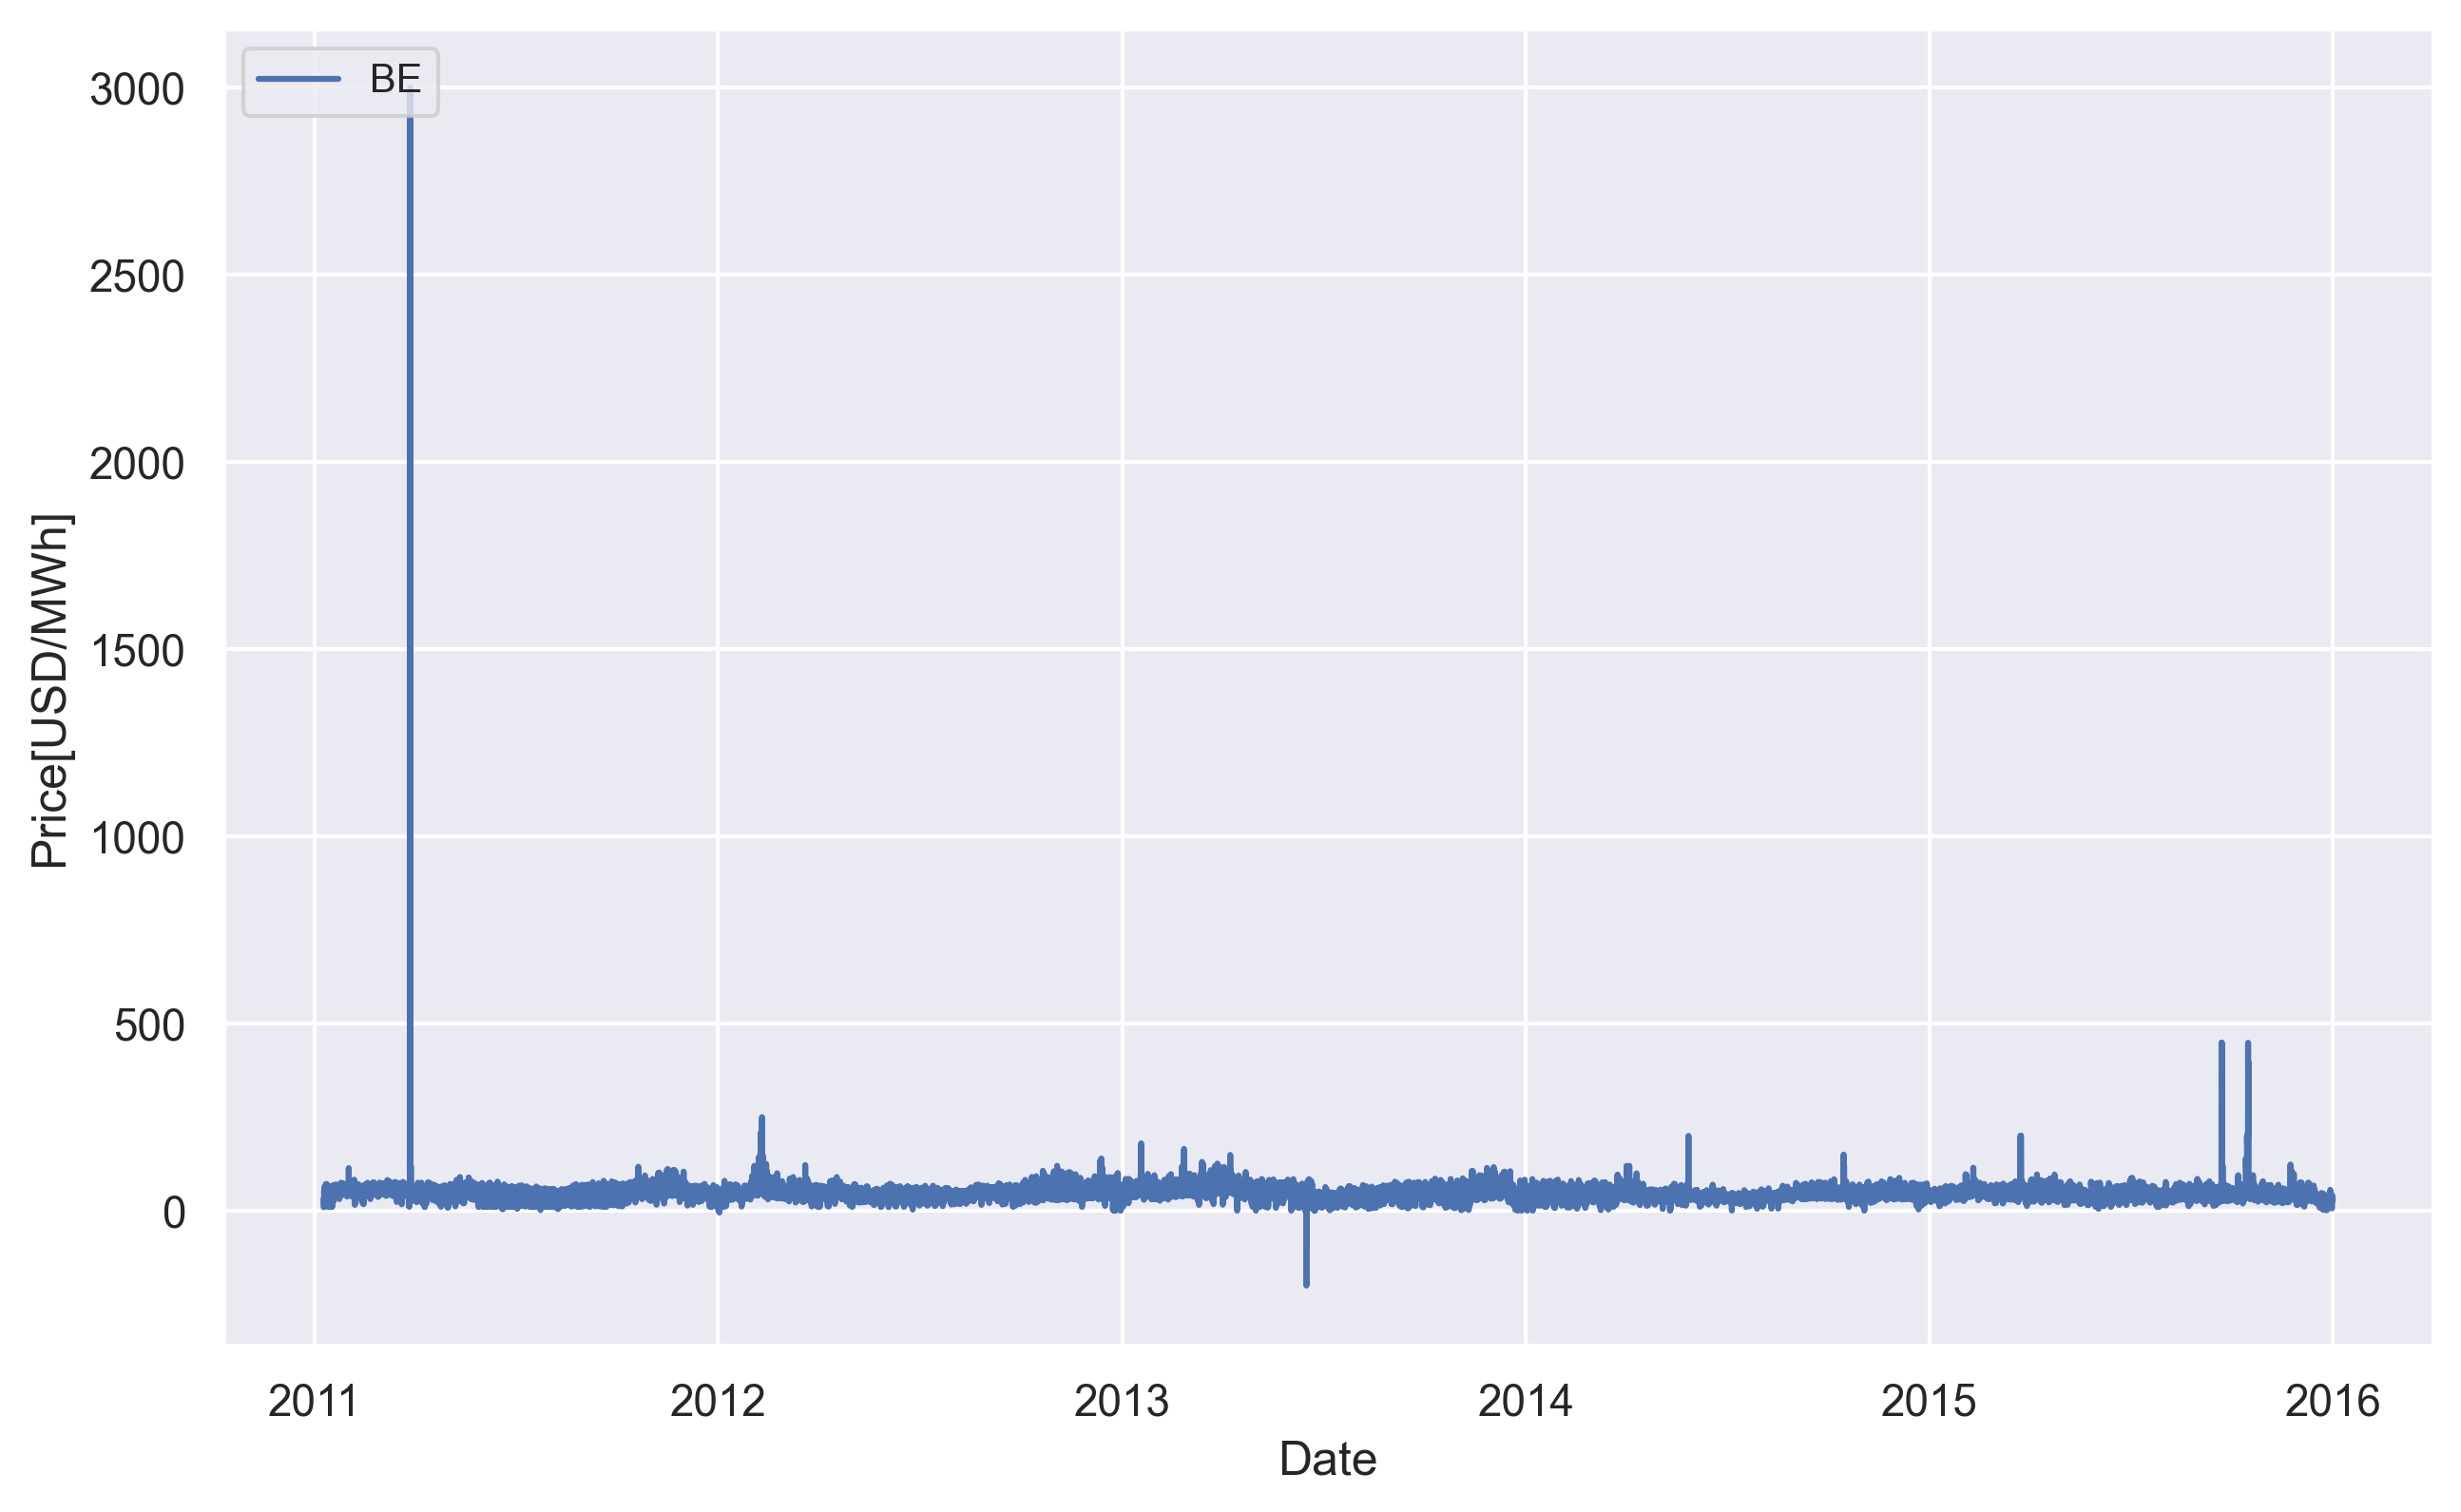

In [168]:
import seaborn as sns
sns.set()
#figu, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.rcParams['figure.dpi']=300
plt.figure(figsize=(10,6))
plt.plot(price)

plt.legend(loc='upper left', fontsize="small", labels=["BE"])
plt.xlabel("Date")
plt.ylabel("Price[USD/MWh]")
plt.show()

In [169]:
print(df_train.shape)
print(df_test.shape)

(43632, 3)
(48, 3)


## Training the TimeGAN synthetizer

In [6]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=50000)
    synth.save('synthesizer_stock.pkl')

2023-04-26 06:17:31.671167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Joint networks training: 100%|█████████| 50000/50000 [40:28:20<00:00,  2.91s/it]


### The generated synthetic stock data

In [7]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████████| 410/410 [00:56<00:00,  7.31it/s]

(52480, 24, 3)


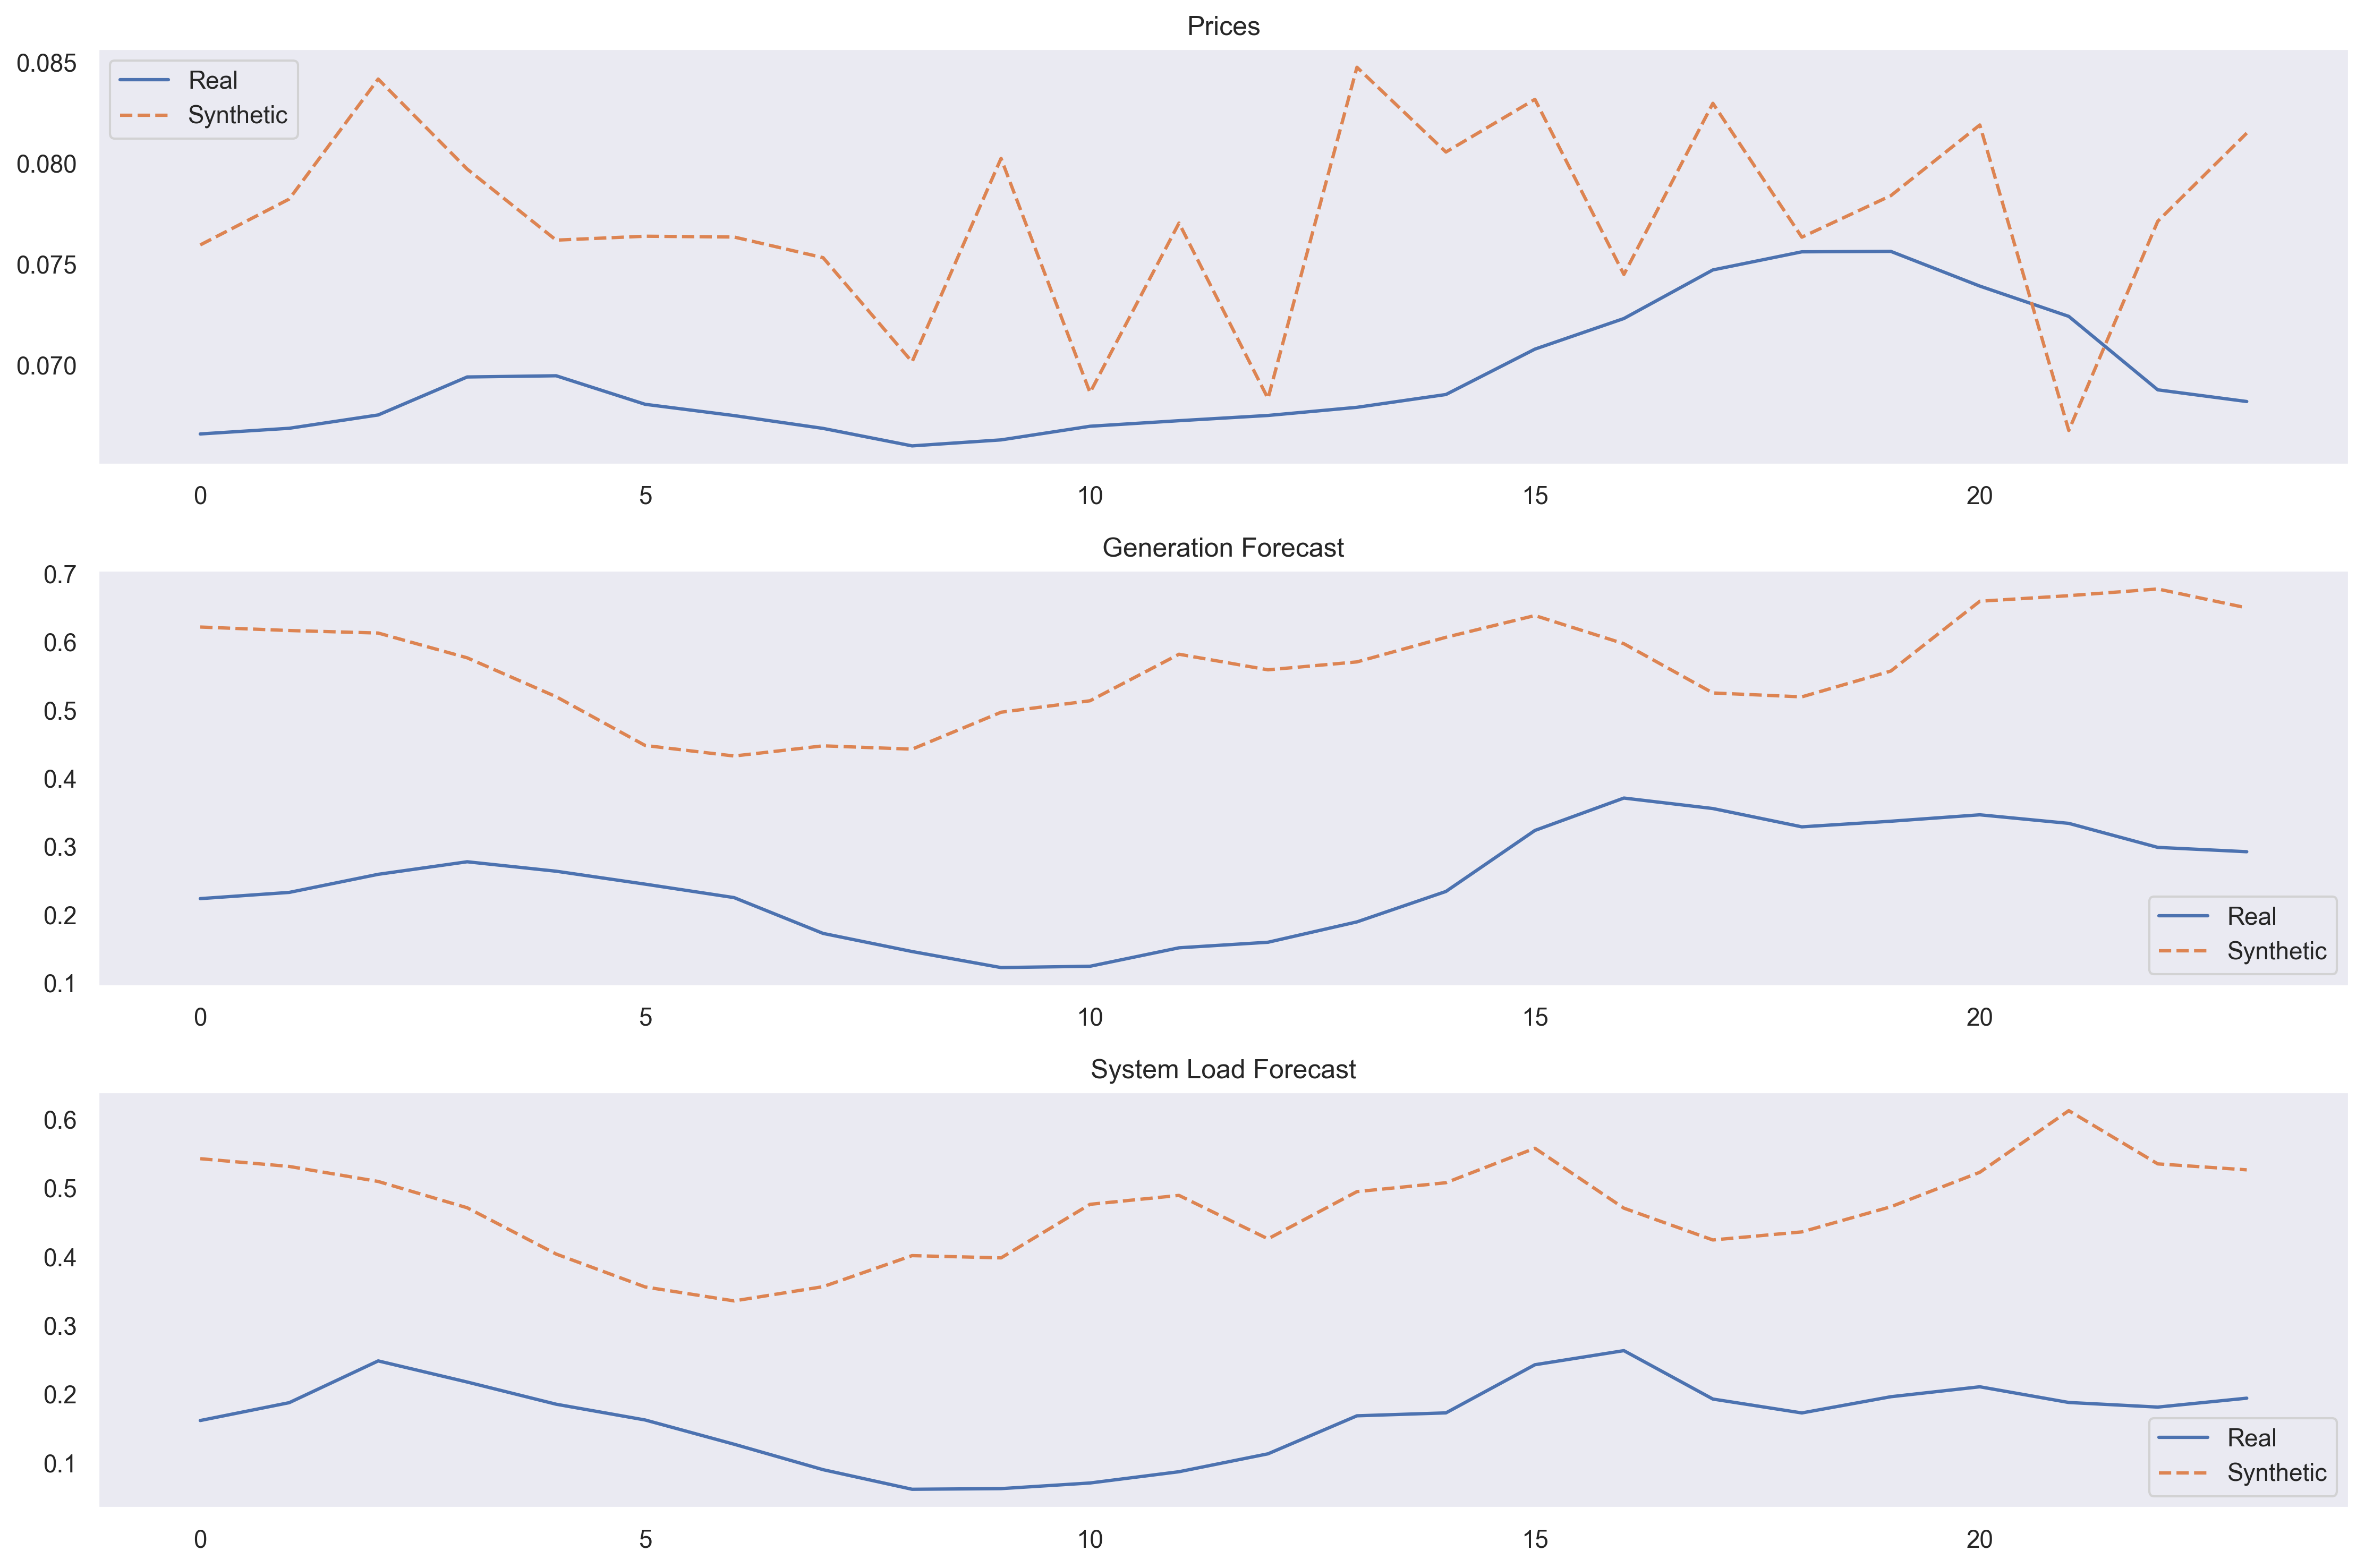

In [171]:
#Reshaping the data
cols = ['Prices','Generation Forecast','System Load Forecast']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [172]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

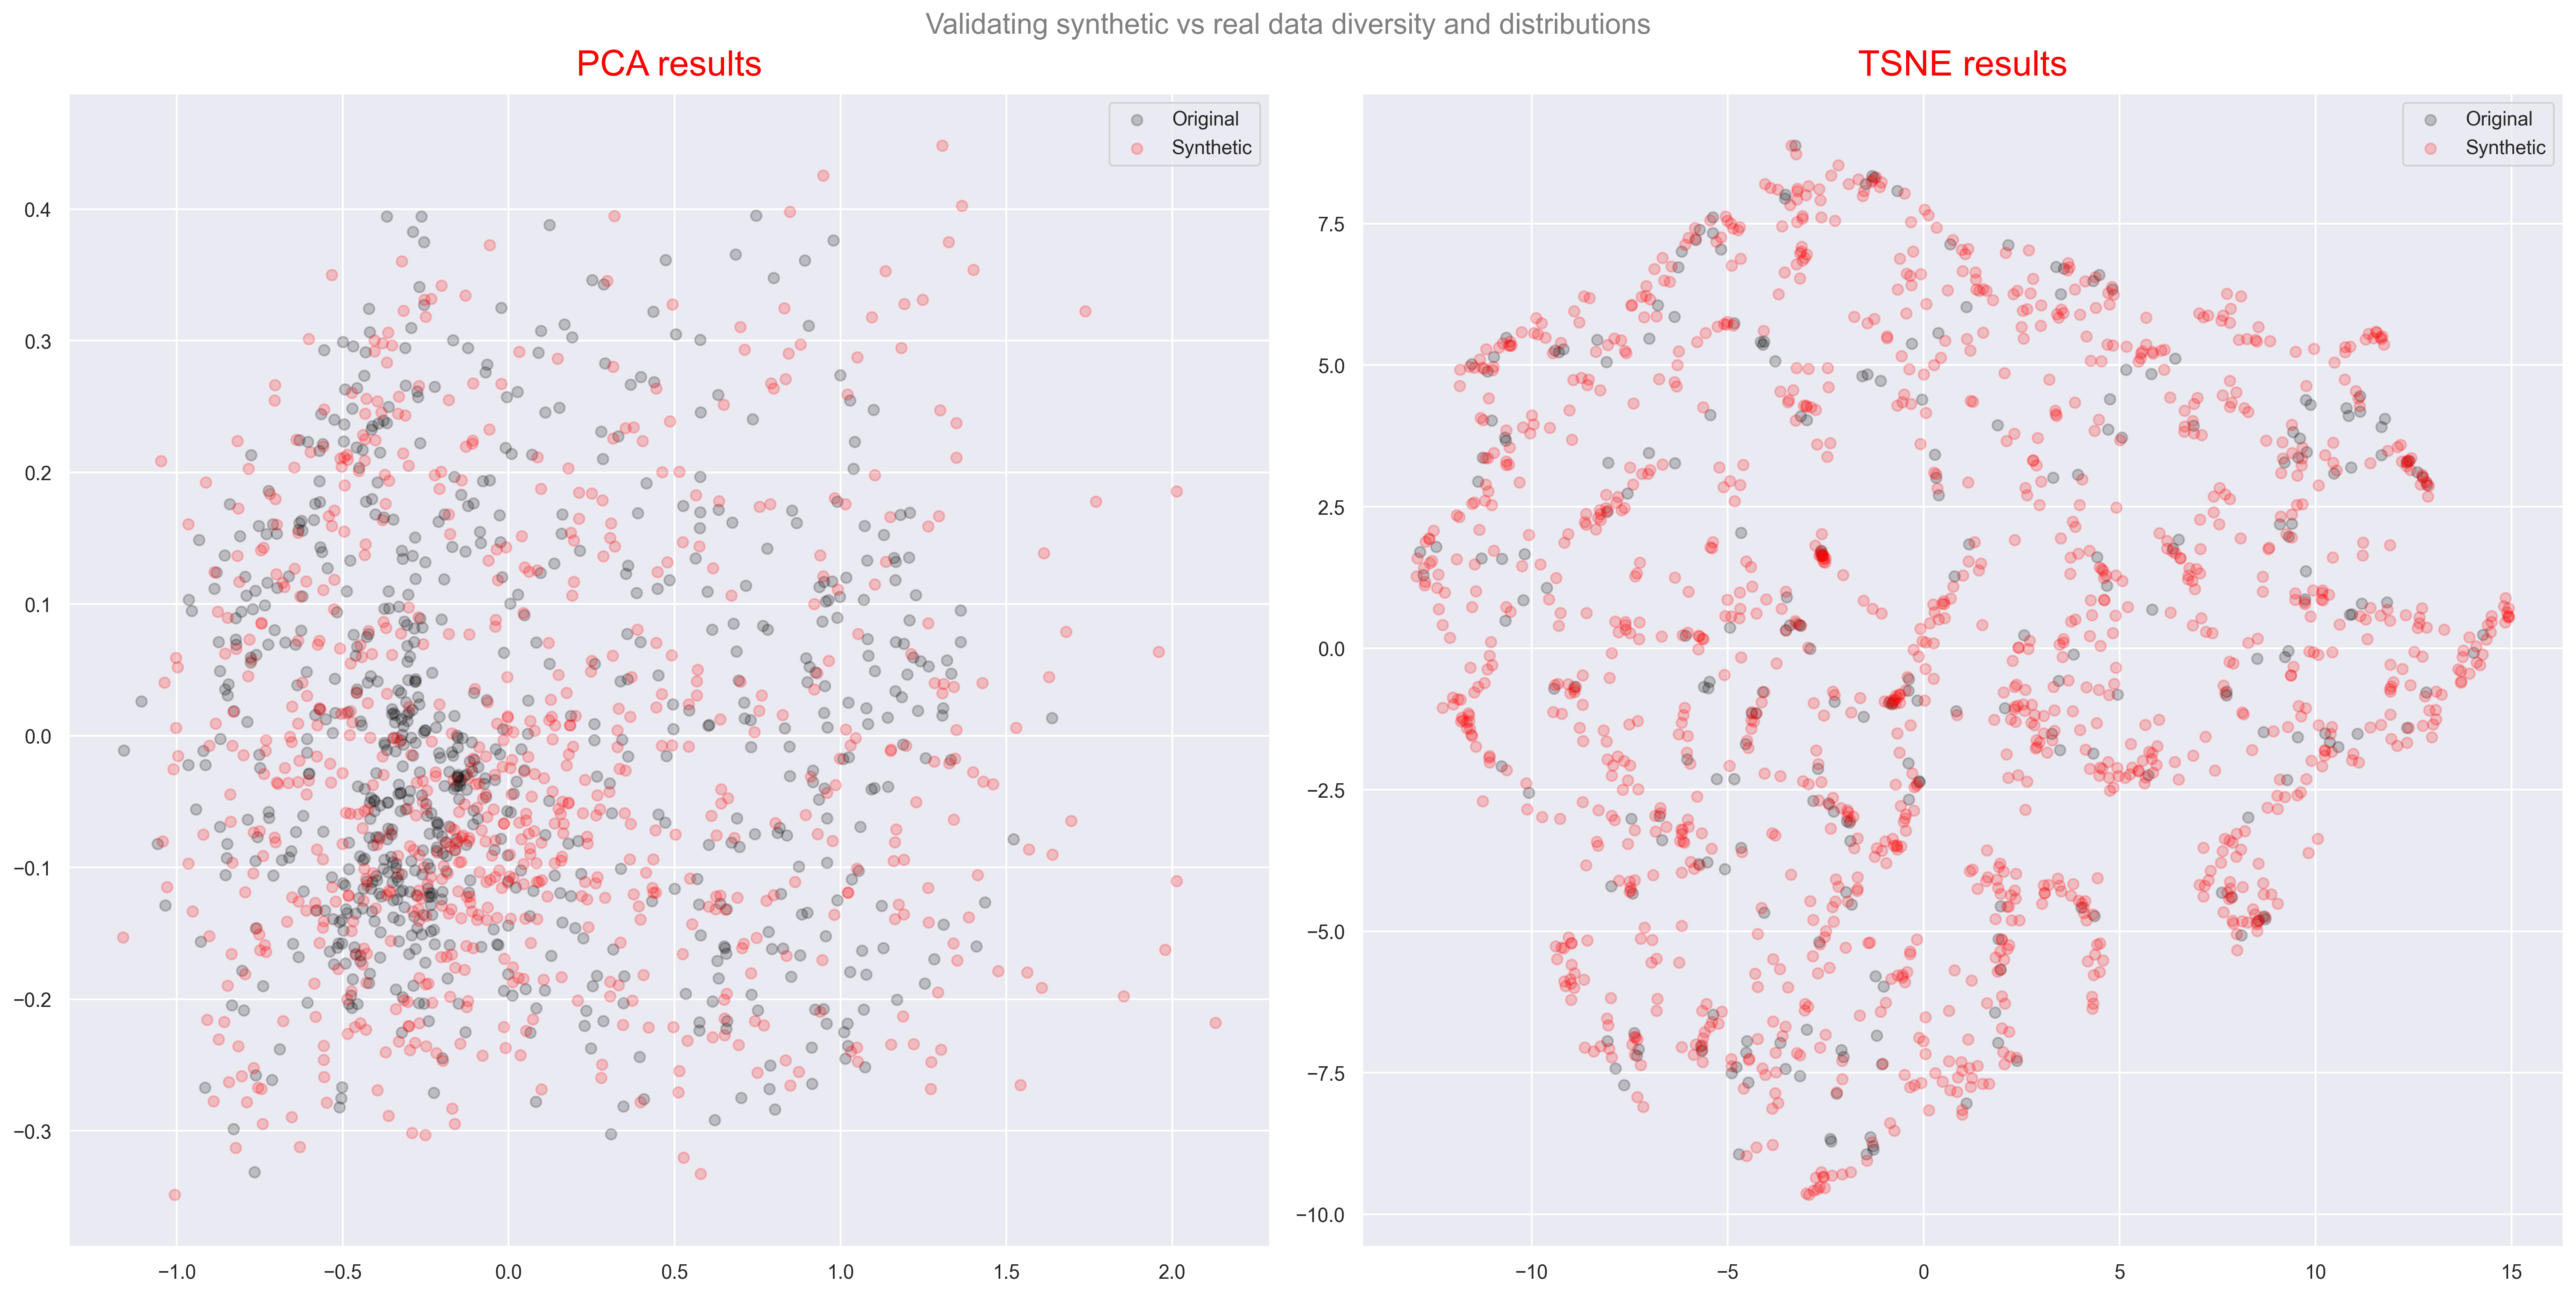

In [205]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [175]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=3,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [176]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.7503435639*n_events)
train_idx = idx[:n_train+1]
test_idx = idx[n_train+1:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

#test set
X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (39312, 23, 3)
Real X train: (39312, 23, 3)
Synthetic y train: (39312, 3)
Real y train: (39312, 3)
Real X test: (13080, 23, 3)
Real y test: (13080, 3)


In [177]:
X_stock_train2 = stock_data[train_idx, -1, :]
X_synth_train2 = synth_data[train_idx, -1, :]

X_stock_train2.shape

(39312, 3)

In [178]:
X_stock_train2

array([[0.07680213, 0.48904976, 0.51544944],
       [0.07065646, 0.42604864, 0.32696629],
       [0.07589559, 0.35941952, 0.31254213],
       ...,
       [0.07720225, 0.67634683, 0.57731742],
       [0.06606127, 0.04108409, 0.04353933],
       [0.07638324, 0.25687496, 0.27808989]])

In [179]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 3s 6ms/step - loss: 0.1168 - val_loss: 0.0381
Epoch 2/200
308/308 [==============================] - 2s 5ms/step - loss: 0.0338 - val_loss: 0.0315


In [180]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 3s 6ms/step - loss: 0.1153 - val_loss: 0.0414
Epoch 2/200
308/308 [==============================] - 2s 5ms/step - loss: 0.0313 - val_loss: 0.0355


In [181]:
#Predictions
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

409/409 [==============================] - 1s 1ms/step


In [182]:
#take only price data
real_predictions

array([[0.07495245, 0.58934665, 0.47446463],
       [0.07554281, 0.33136368, 0.25959677],
       [0.08551914, 0.7558829 , 0.69027823],
       ...,
       [0.07975907, 0.68488246, 0.6001241 ],
       [0.07467141, 0.3571642 , 0.2822125 ],
       [0.07483517, 0.47851592, 0.3858245 ]], dtype=float32)

In [183]:
#price array for real_prediction
r_pred = real_predictions.flatten()
re_pred = r_pred[0:len(r_pred):3]

In [184]:
re_pred.shape

(13080,)

In [185]:
#price array for synth_prediction
s_pred = synth_predictions.flatten()
sy_pred = s_pred[0:len(r_pred):3]

In [186]:
sy_pred.shape

(13080,)

In [187]:
y_stock_test

array([[0.07045952, 0.55995295, 0.35353933],
       [0.07971241, 0.35681863, 0.28230337],
       [0.07642076, 0.77244715, 0.74606742],
       ...,
       [0.08194748, 0.71589027, 0.58848315],
       [0.08057831, 0.32774501, 0.30617978],
       [0.06539231, 0.4029554 , 0.34026685]])

In [188]:
# price data for y_stock_test
y_st = y_stock_test.flatten()
y_stock = y_st[0:len(y_st):3]
y_stock[:10]

array([0.07045952, 0.07971241, 0.07642076, 0.06578618, 0.0776649 ,
       0.0845733 , 0.08068146, 0.07783057, 0.06875274, 0.08596436])

In [189]:
y_stock_train

array([[0.07680213, 0.48904976, 0.51544944],
       [0.07065646, 0.42604864, 0.32696629],
       [0.07589559, 0.35941952, 0.31254213],
       ...,
       [0.07720225, 0.67634683, 0.57731742],
       [0.06606127, 0.04108409, 0.04353933],
       [0.07638324, 0.25687496, 0.27808989]])

In [190]:
# price data for y_stock_train
y_s = y_stock_train.flatten()
y_ss = y_s[0:len(y_st):3]

In [149]:
# MASE in-sample data check on it

In [191]:
#Summarize the metrics here as a pandas dataframe
metrics_dict = {'MAE': [MAE(y_stock, re_pred),
                        MAE(y_stock, sy_pred)],
                'rMAE':[rMAE(y_stock, re_pred, m ='D',freq='1H'),
                        rMAE(y_stock, sy_pred,m='D',freq='1H')],
                'MAPE':[MAPE(y_stock, re_pred),
                       MAPE(y_stock, sy_pred)],
                'sMAPE':[sMAPE(y_stock, re_pred),
                        sMAPE(y_stock, sy_pred)],
                'MASE': [MASE(y_stock, re_pred, X_stock_train2,m='D',freq='1H'),
                         MASE(y_stock, sy_pred, X_synth_train2,m='D',freq='1H')],
               'RMSE':[RMSE(y_stock,re_pred),
                      RMSE(y_stock, sy_pred)]
               }

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

MAE      rMAE      MAPE     sMAPE      MASE      RMSE
Real       0.004411  0.732037  0.057177  0.057229  0.033637  0.006467
Synthetic  0.004048  0.671744  0.052168  0.052455  0.030093  0.006194

In [192]:
y_stock

array([0.07045952, 0.07971241, 0.07642076, ..., 0.08194748, 0.08057831,
       0.06539231])

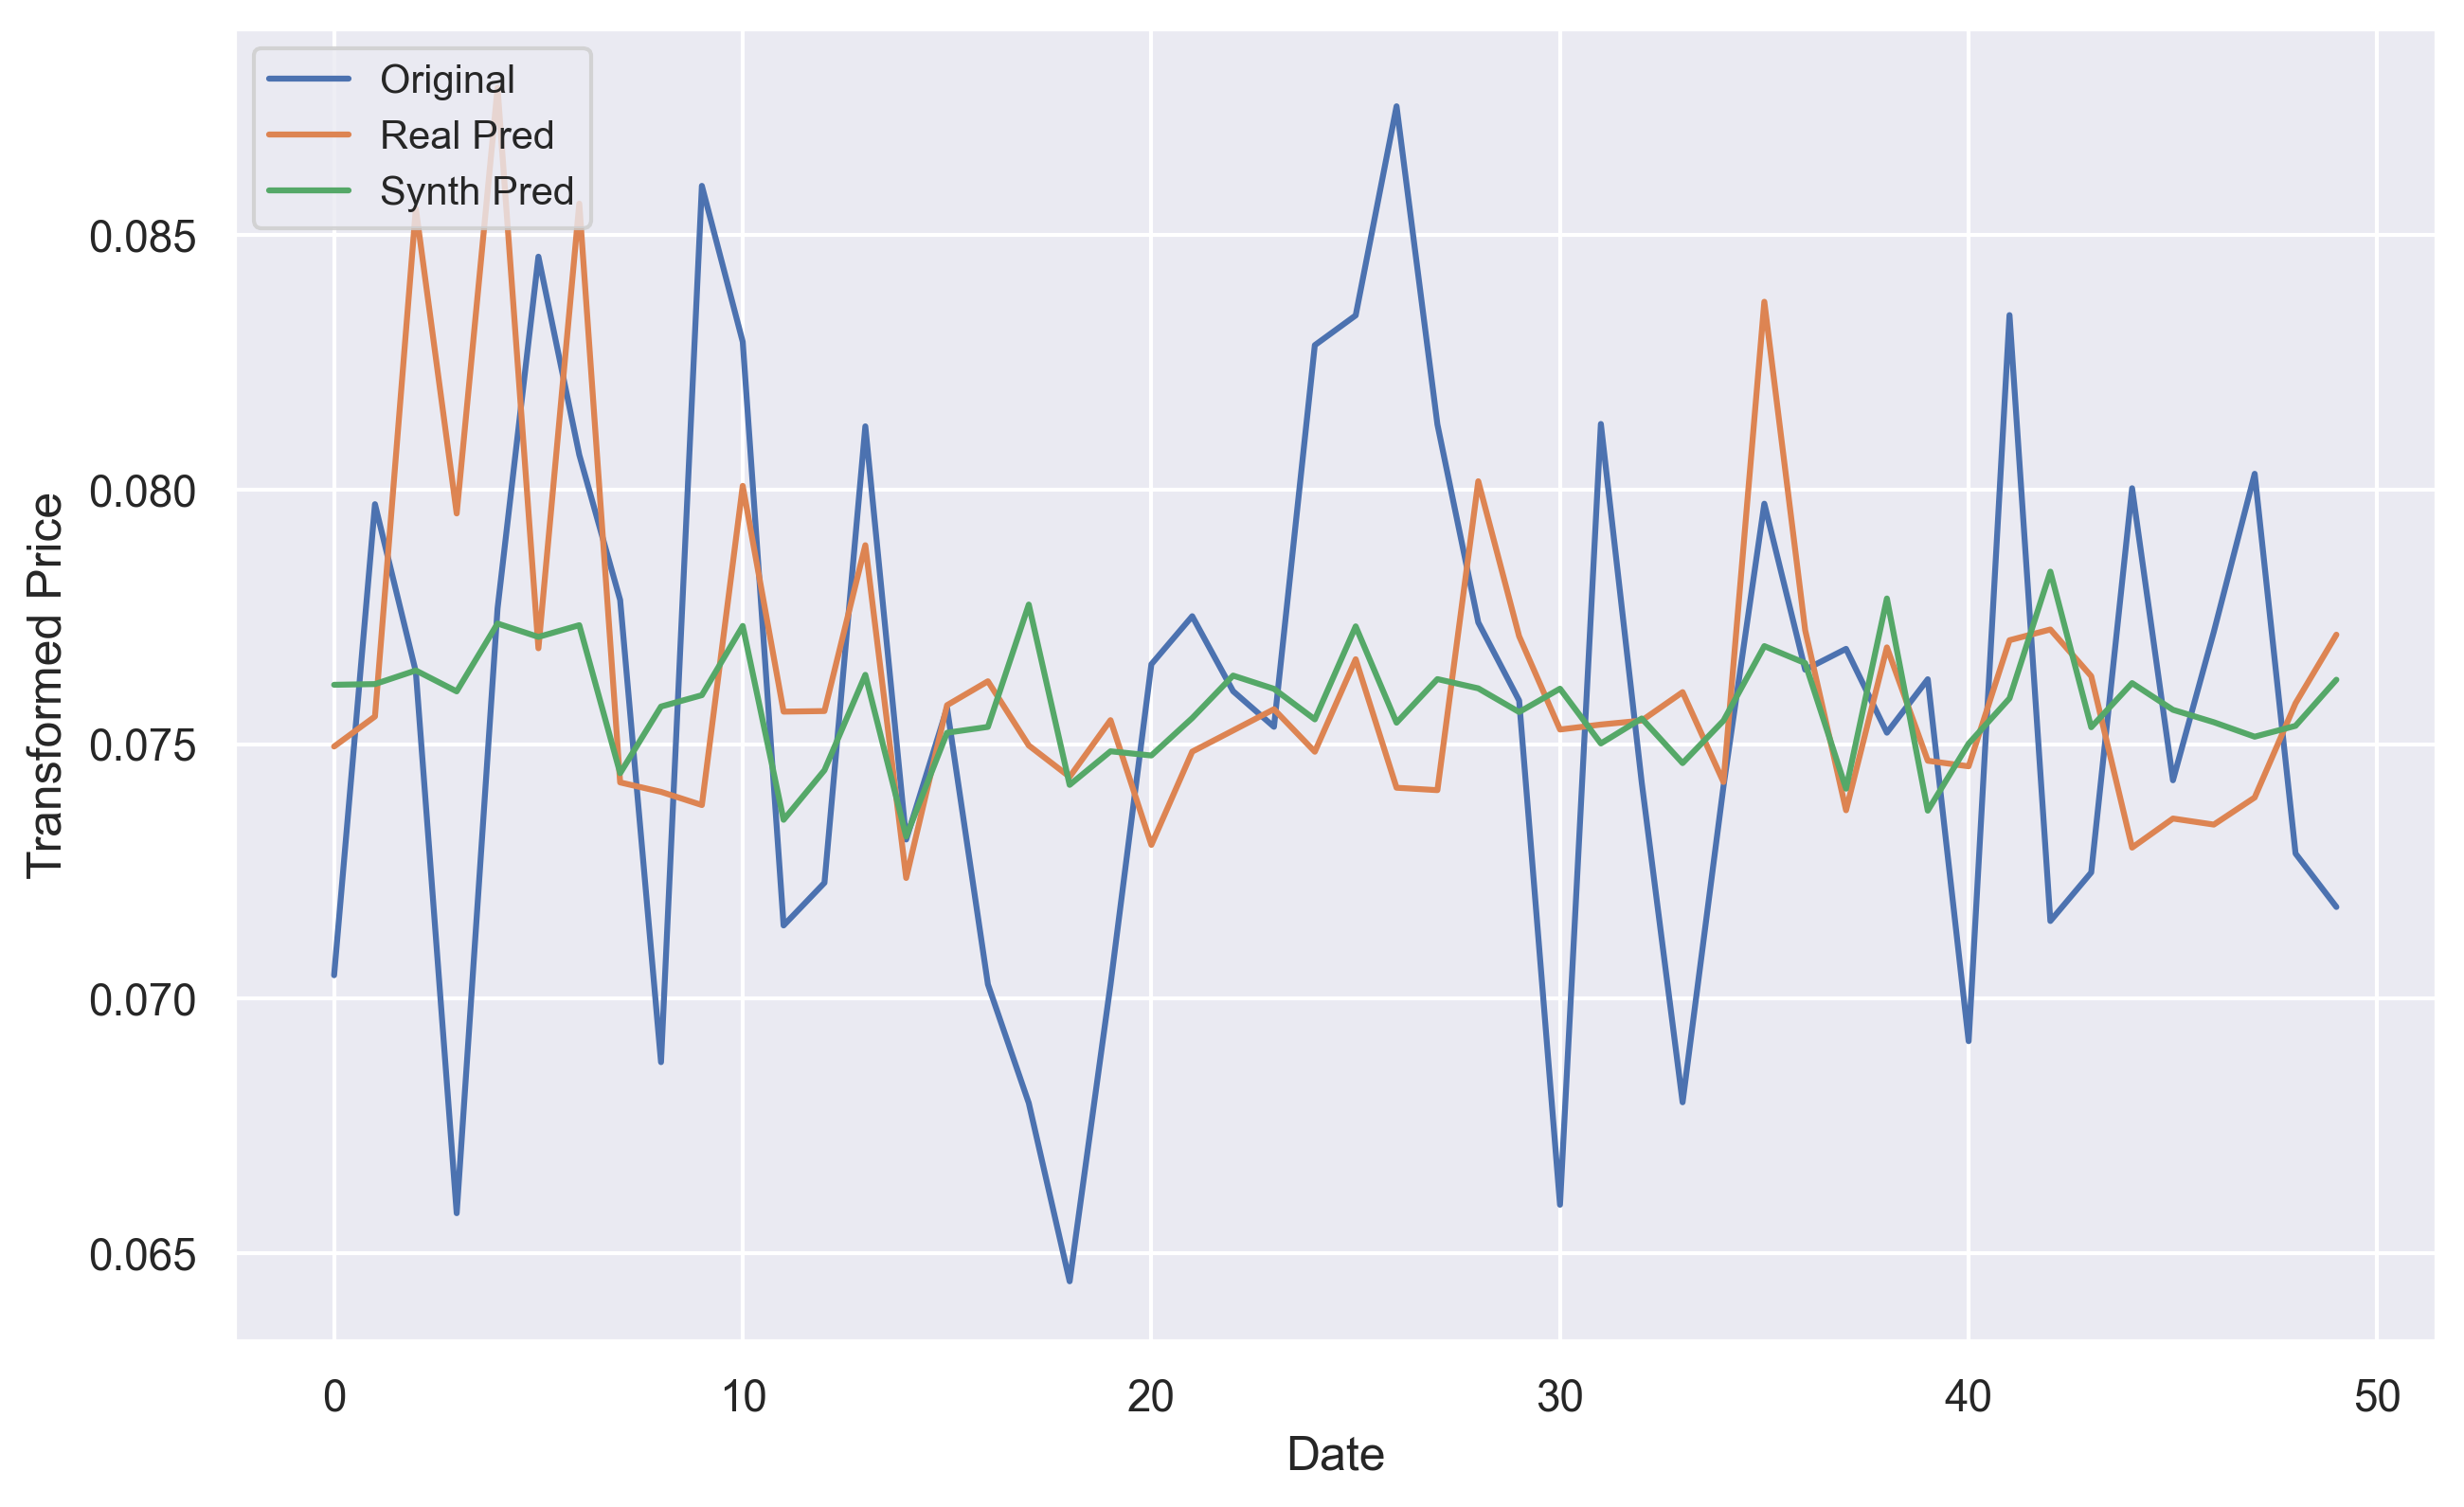

In [206]:
#figu, ax = plt.subplots(nrows =1, ncols=1, figsize = (10,6))
plt.rcParams['figure.dpi'] = 300

plt.figure(figsize = (10,6))
plt.plot(y_stock[:50])
plt.plot(re_pred[:50])
plt.plot(sy_pred[:50])


plt.legend(loc = 'upper left',fontsize = 'small',labels=["Original","Real Pred", "Synth Pred"])
plt.xlabel("Date")
plt.ylabel("Transformed Price")
plt.show()


In [212]:
from terminaltables import AsciiTable
data = [['Metrics','Best DNN', 'Best LEAR', 'TimeGAN Real', 'TimeGAN Synth'],['rMAE',0.597,0.649,0.732037,0.671744], ['MAE',6.068,6.594,0.004411,0.004048 ],['MAPE [%]',24.650,22.645,0.057177*100,0.052168*100],['sMAPE [%]',14.106,15.954,0.057229*100,0.052455*100],['MASE','N/A','N/A',0.033637,0.030093],['RMSE', 15.950,16.291,0.006467,0.006194 ]]


In [213]:
table = AsciiTable(data, title='BE')
table.justify = 'center'
table.inner_row_border = True
print(table.table)

+BE---------+----------+-----------+--------------+---------------+
| Metrics   | Best DNN | Best LEAR | TimeGAN Real | TimeGAN Synth |
+-----------+----------+-----------+--------------+---------------+
| rMAE      | 0.597    | 0.649     | 0.732037     | 0.671744      |
+-----------+----------+-----------+--------------+---------------+
| MAE       | 6.068    | 6.594     | 0.004411     | 0.004048      |
+-----------+----------+-----------+--------------+---------------+
| MAPE [%]  | 24.65    | 22.645    | 5.7177       | 5.2168        |
+-----------+----------+-----------+--------------+---------------+
| sMAPE [%] | 14.106   | 15.954    | 5.7229       | 5.2455        |
+-----------+----------+-----------+--------------+---------------+
| MASE      | N/A      | N/A       | 0.033637     | 0.030093      |
+-----------+----------+-----------+--------------+---------------+
| RMSE      | 15.95    | 16.291    | 0.006467     | 0.006194      |
+-----------+----------+-----------+------------